### Imports

In [1]:
import sys
import matplotlib.pyplot as plt
import torch
sys.path.append('..')
from src.feature_extraction import FeatureExtractionConfig
from src.segmentation import Segmenter,SegmenterConfig
from src.dataset import ISICDataset, EMD6Dataset
from src.utils import seed_everything, display_segmentation_results, bilateral_solver_output, graph_to_mask
from definitions import EMDS_6_DIR, ISIC_DIR

In [2]:
# %pip install git+https://github.com/lucasb-eyer/pydensecrf.git

### Reproducibility

In [3]:
SEED = 42
seed_everything(SEED)

### Load the dataset

In [4]:
dataset = ISICDataset(root=ISIC_DIR, return_mask=True)
print(len(dataset))

900


### Load an example

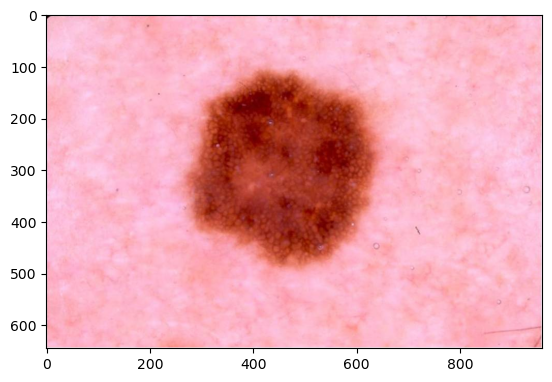

In [5]:
sample = dataset[154]
plt.imshow(sample['image'])

### Segmentation

- DeepCut : NCUT Loss

In [6]:
config = SegmenterConfig(
    segmentation_type="ncut",
    alpha=5.0,
    feature_extractor_config=FeatureExtractionConfig(
        model_name="facebook/dino-vits8",
        device="cuda",
        feature_type="key",
    ),
    activation="silu",
    num_layers=1,
    conv_type="arma",
    hidden_dim=32,
    num_clusters=2,
    device="cuda",
    threshold=0.6
)

In [7]:
segmenter = Segmenter(config)

Some weights of ViTModel were not initialized from the model checkpoint at facebook/dino-vits8 and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Optimizing:   0%|          | 0/30 [00:00<?, ?it/s]

IoU: 0.962


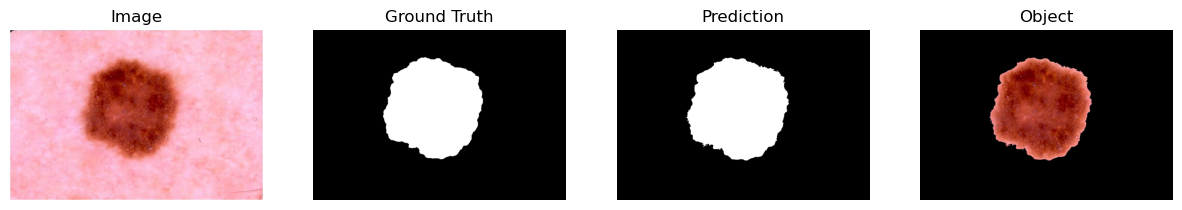

In [8]:
result = segmenter.segment(sample['image'], lr=0.001, n_iters=30, show_progress=True)
display_segmentation_results(sample, result['mask'].astype(int).astype(bool))

In [9]:
torch.cuda.empty_cache()

- DeepCut : CC Loss

In [10]:
config = SegmenterConfig(
    segmentation_type="cc",
    alpha=4.0,
    feature_extractor_config=FeatureExtractionConfig(
        model_name="facebook/dino-vits8",
        device="cuda",
        feature_type="key",
    ),
    activation="silu",
    num_layers=1,
    conv_type="gcn",
    hidden_dim=32,
    num_clusters=2,
    device="cuda",
    threshold=0.6
)

In [11]:
segmenter = Segmenter(config)

Some weights of ViTModel were not initialized from the model checkpoint at facebook/dino-vits8 and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Optimizing:   0%|          | 0/100 [00:00<?, ?it/s]

IoU: 0.964


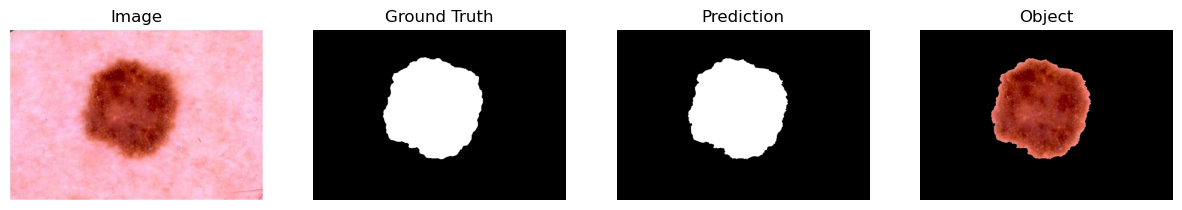

In [12]:
result = segmenter.segment(sample['image'], lr=0.001, n_iters=100, show_progress=True)
display_segmentation_results(sample, result['mask'].astype(bool).astype(int))

In [13]:
torch.cuda.empty_cache()

- UnSegGNet / UnSeGArmaNet

In [14]:
config = SegmenterConfig(
    segmentation_type="dmon",
    alpha=5.0,
    feature_extractor_config=FeatureExtractionConfig(
        model_name="facebook/dino-vits8",
        device="cuda",
        feature_type="key",
    ),
    activation="silu",
    num_layers=1,
    conv_type="arma",
    hidden_dim=32,
    num_clusters=2,
    device="cuda",
    threshold=0.6
)

In [15]:
segmenter = Segmenter(config)

Some weights of ViTModel were not initialized from the model checkpoint at facebook/dino-vits8 and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Optimizing:   0%|          | 0/70 [00:00<?, ?it/s]

IoU: 0.907


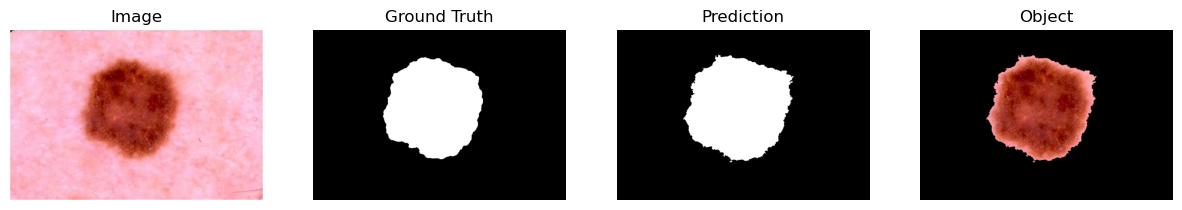

In [16]:
result = segmenter.segment(sample['image'], lr=0.001, n_iters=70, show_progress=True)
display_segmentation_results(sample, result['mask'].astype(bool).astype(int))